# Business Case 1

Group members:
- Lorenzo Pigozzi	--- m20200745
- Nguyen Huy Phuc	--- m20200566
- Ema Mandura	  --- m20200647


## Hotel

<a class="anchor" id="0.1"></a>
# **Table of Contents**

1.	[Importing data and libraries](#1)   
2.	[Exploratory data analysis (EDA)](#2)       
3.	[Data preprocessing](#3)  
4.  [Cluster analysis](#4)      
5.  [Merging the results](#5)

# 1. Importing data and libraries <a class="anchor" id="1"></a>

In [1]:
import numpy as np
import pandas as pd
import math
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path
from joblib import dump
import time
# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer,QuantileTransformer, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score,auc, confusion_matrix, classification_report
#sklearn categorical encoding
import category_encoders as ce
#sklearn modelling
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split, KFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

#Light GBM
import lightgbm as lgb

#Visualization
import matplotlib.cm as cm
from yellowbrick.cluster import KElbowVisualizer
from sklearn import random_projection

#sompy
import sompy
from sompy.visualization.mapview import View2D
from sompy.visualization.bmuhits import BmuHitsView
from sompy.visualization.hitmap import HitMapView

# profiling
from pandas_profiling import ProfileReport
# plotly
import plotly.graph_objects as go # We are only importing the 'graph_objects' module from plotly here
import psutil 
# DECISION TREE
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.model_selection import train_test_split
import graphviz

#PROJECT_ROOT = Path(os.path.abspath('')).resolve()
#warnings
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger('matplotlib.font_manager').disabled = True


In [2]:
data = pd.read_csv('data/H2.csv')

In [3]:
data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
0,0,6,2015,July,27,1,0,2,1,0.0,...,No Deposit,6,NULL,0,Transient,0.00,0,0,Check-Out,2015-07-03
1,1,88,2015,July,27,1,0,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-07-01
2,1,65,2015,July,27,1,0,4,1,0.0,...,No Deposit,9,NULL,0,Transient,68.00,0,1,Canceled,2015-04-30
3,1,92,2015,July,27,1,2,4,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,2,Canceled,2015-06-23
4,1,100,2015,July,27,2,0,2,2,0.0,...,No Deposit,9,NULL,0,Transient,76.50,0,1,Canceled,2015-04-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79325,0,23,2017,August,35,30,2,5,2,0.0,...,No Deposit,394,NULL,0,Transient,96.14,0,0,Check-Out,2017-09-06
79326,0,102,2017,August,35,31,2,5,3,0.0,...,No Deposit,9,NULL,0,Transient,225.43,0,2,Check-Out,2017-09-07
79327,0,34,2017,August,35,31,2,5,2,0.0,...,No Deposit,9,NULL,0,Transient,157.71,0,4,Check-Out,2017-09-07
79328,0,109,2017,August,35,31,2,5,2,0.0,...,No Deposit,89,NULL,0,Transient,104.40,0,0,Check-Out,2017-09-07


In [4]:
data.loc[:,data.dtypes != "O"].columns.drop('IsCanceled')

Index(['LeadTime', 'ArrivalDateYear', 'ArrivalDateWeekNumber',
       'ArrivalDateDayOfMonth', 'StaysInWeekendNights', 'StaysInWeekNights',
       'Adults', 'Children', 'Babies', 'IsRepeatedGuest',
       'PreviousCancellations', 'PreviousBookingsNotCanceled',
       'BookingChanges', 'DaysInWaitingList', 'ADR',
       'RequiredCarParkingSpaces', 'TotalOfSpecialRequests'],
      dtype='object')

In [5]:
numeric_feats = data.loc[:,data.dtypes != "O"].columns.drop('IsCanceled')
cat_feats = data.loc[:,data.dtypes == "O"].columns
target = 'IsCanceled'

# 2. Exploratory data analysis (EDA) <a class="anchor" id="2"></a>

In [6]:
#find features with correlations greater than 0.9 in order to remove them
def correlation_check(df, limit = 0.90, drop = False):
    corr = df.corr()
    mask = np.triu(np.ones(corr.shape), k=1).astype(bool)
    corr_no_diag = corr.where(mask)
    coll = [c for c in corr_no_diag.columns if any(abs(corr_no_diag[c]) > limit)]        
    #df.drop(coll,axis = 1,inplace=True)
    print('High correlation columns are:', coll)
def corrheatmap(dataframe):
    sns.set(style="whitegrid")
    # Compute the correlation matrix
    corr = dataframe.corr() #Getting correlation of numerical variables
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(16, 8))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, annot=True,annot_kws={"fontsize":10}, linewidths=.5,vmin = -1, vmax = 1, ax=ax)
    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

def boxplot_withoutLabels(df):
    plot_features = df.columns
    #Prepare figure layout
    rows = int(math.ceil(df.shape[1]/8))
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=8, figsize=(16,4*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), plot_features):
        sns.boxplot(y=df.loc[:,i[1]], ax=i[0])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)

    # Finalize the plot
    plt.subplots_adjust(wspace=2,hspace = 0.5)
    fig.suptitle("Box plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def displot_all(df, columns, target):
    #Prepare figure layout
    rows = int(math.ceil(columns.shape[0]/5))
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=5, figsize=(15,3*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), columns):
        sns.histplot(x=df.loc[:,i[1]], ax=i[0], hue = df[target],palette=["b", "r"])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        i[0].set_xlabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Dist plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def countplot_all(df, columns):
    #Prepare figure layout
    rows = int(math.ceil(columns.shape[0]/5))
    sns.set_style("whitegrid")
    fig, axes = plt.subplots(nrows = rows, ncols=5, figsize=(15,3*rows))

    # Draw the boxplots
    for i in zip(axes.flatten(), columns):
        sns.countplot(x=df.loc[:,i[1]], ax=i[0])      
        i[0].set_title(i[1])
        i[0].set_ylabel("")
        i[0].set_xlabel("")
        for tick in i[0].get_xticklabels():
            tick.set_rotation(-25)
    # Finalize the plot
    plt.subplots_adjust(wspace=0.5,hspace = 0.5)
    fig.suptitle("Count plots", fontsize=25)
    #sns.despine(bottom=True)
    plt.show()
    
def corrheatmap(dataframe, method = "pearson"):
    sns.set(style="white")

    # Compute the correlation matrix
    corr = dataframe.corr(method= method) #Getting correlation of numerical variables

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool) #Return an array of zeros (Falses) with the same shape and type as a given array
    mask[np.triu_indices_from(mask)] = True #The upper-triangle array is now composed by True values
    
    # Set up the matplotlib figure
    fig, ax = plt.subplots(figsize=(20, 16))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True) #Make a diverging palette between two HUSL colors. Return a matplotlib colormap object.

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True,annot=True, linewidths=.5,vmin = -1, vmax = 1, ax=ax)

    # Layout
    plt.subplots_adjust(top=0.95)
    plt.suptitle("Correlation matrix", fontsize=15)
    plt.yticks(rotation=0, fontsize = 14)
    plt.xticks(rotation=90, fontsize = 14)
    # Fixing the bug of partially cut-off bottom and top cells
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

    plt.show()      
    
def weight_of_variable(df, column, target, plot = True, sortby = 'Total count'):
    # Count total observations
    total = df[[column, target]].groupby(by = column,).count().sort_values(by = target, ascending = False)

    # Count
    with_target = df[[column, target]].groupby(by = column).sum().sort_values(by = target, ascending = False)
    
    weight = (df[[column, target]].groupby(by = column).sum().sort_values(by = target, ascending = False) / 
    (df[[column, target]].groupby(by = column).count().sort_values(by = target, ascending = False))).sort_values(by = target, ascending = False)
    
    concat_df = pd.concat([total, with_target, weight],axis = 1)
    
    out = pd.DataFrame(concat_df.values,index=concat_df.index, columns=['Total count', 'Cancelled count', 'Weight'])
    # Explore feature vs target by catplot
    if plot == True:
        g = sns.catplot(x=target,y=column,data=df,kind="bar", size = 4 , palette = "muted",orient='h',height=.5, aspect=2)
        #g.set(ylim=(lower, upper)) 
        g.despine(left=True)
        g.fig.set_figwidth(8)
        g.fig.set_figheight(3*ceil(len(df[column].unique())/10))
        g.set_ylabels("Income probability")
        # Rotate the labels
        for ax in g.axes.flat:
            for label in ax.get_xticklabels():
                label.set_rotation(-45)

    return out.astype({'Total count':'int', 'Cancelled count':'int64'}).sort_values(by = sortby ,ascending = False)

## Check for missing values:

In [7]:
data.isna().sum()

IsCanceled                      0
LeadTime                        0
ArrivalDateYear                 0
ArrivalDateMonth                0
ArrivalDateWeekNumber           0
ArrivalDateDayOfMonth           0
StaysInWeekendNights            0
StaysInWeekNights               0
Adults                          0
Children                        4
Babies                          0
Meal                            0
Country                        24
MarketSegment                   0
DistributionChannel             0
IsRepeatedGuest                 0
PreviousCancellations           0
PreviousBookingsNotCanceled     0
ReservedRoomType                0
AssignedRoomType                0
BookingChanges                  0
DepositType                     0
Agent                           0
Company                         0
DaysInWaitingList               0
CustomerType                    0
ADR                             0
RequiredCarParkingSpaces        0
TotalOfSpecialRequests          0
ReservationSta

Great news, no missing data at all!

## Checking duplicated observations

In [8]:
# Checking duplicated observations
data.loc[data.duplicated(keep=False), :]

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,ReservationStatusDate
8,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
9,1,62,2015,July,27,2,2,3,2,0.0,...,No Deposit,8,NULL,0,Transient,76.50,0,1,No-Show,2015-07-02
10,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
12,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
17,0,43,2015,July,27,3,0,2,2,0.0,...,No Deposit,1,NULL,0,Transient-Party,86.00,0,0,Check-Out,2015-07-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79292,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79293,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79294,0,63,2017,August,35,31,0,3,3,0.0,...,No Deposit,9,NULL,0,Transient-Party,195.33,0,2,Check-Out,2017-09-03
79312,0,175,2017,August,35,31,1,3,1,0.0,...,No Deposit,42,NULL,0,Transient,82.35,0,1,Check-Out,2017-09-04


## Check for variables univariate distribution

### Numeric features

NumExpr defaulting to 8 threads.


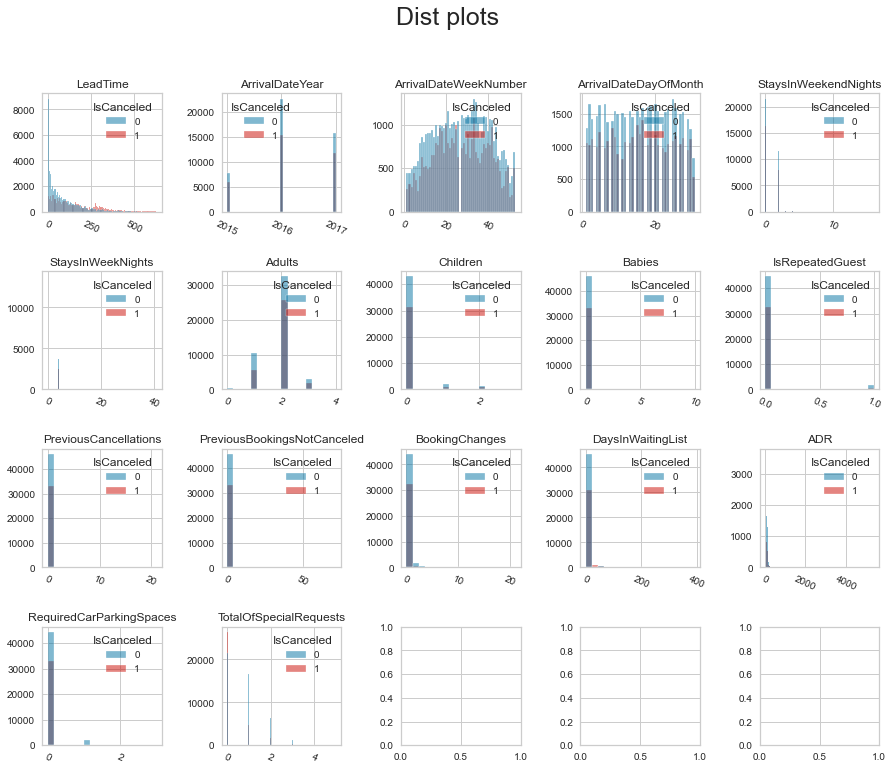

In [9]:
displot_all(data,numeric_feats,target=target)  

A lot of features have outliners, I think in the next EDA steps, we should divide the features by their charatacteristics and try to understand them

In [ ]:
sns.displot()

## Categorical features

In [10]:
cat_feats

Index(['ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment',
       'DistributionChannel', 'ReservedRoomType', 'AssignedRoomType',
       'DepositType', 'Agent', 'Company', 'CustomerType', 'ReservationStatus',
       'ReservationStatusDate'],
      dtype='object')

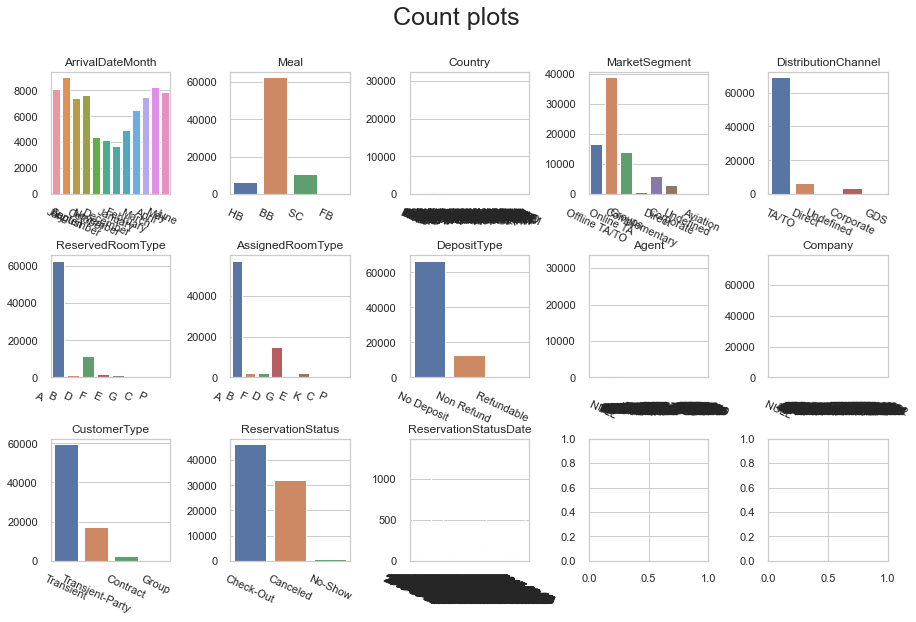

In [37]:
countplot_all(data,cat_feats)

### Reservation Status

,Total count,Cancelled count,Weight
Check-Out,46228,0,0.0
Canceled,32186,32186,1.0
No-Show,916,916,1.0


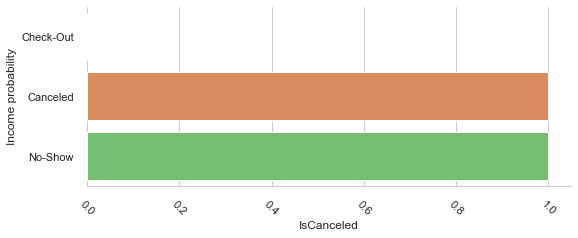

In [38]:
weight_of_variable(data,"ReservationStatus",target)

This features must be removed because it is only available after the customer cancelled

### **Meal**

,Total count,Cancelled count,Weight
BB,62305,26667,0.428007
SC,10564,3963,0.375142
HB,6417,2437,0.379772
FB,44,35,0.795455


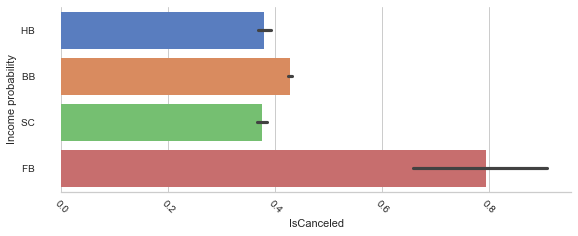

In [21]:
weight_of_variable(data,"Meal",target)

#### Notations:
The probability that customers who chose Full-Board as their meal obtion is the highest amongst all. However, the number of the FB is very small in comparision with the other 3 options given. While Half-board and Undefined is relatively the same, the people with Bed-Breakfast is slightly higher

### MarketSegment

,Total count,Cancelled count,Weight
Online TA,38748,14491,0.373981
Offline TA/TO,16747,7173,0.428316
Groups,13975,9623,0.688587
Direct,6093,1056,0.173314
Corporate,2986,641,0.214668
Complementary,542,64,0.118081
Aviation,237,52,0.219409
Undefined,2,2,1.000000


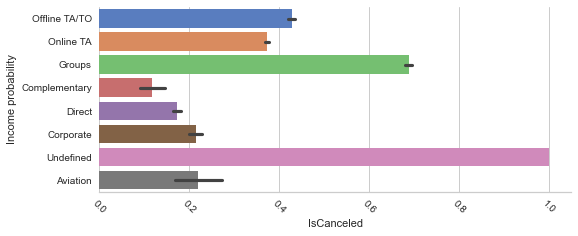

In [23]:
weight_of_variable(data,"MarketSegment",target)

### DistributionChannel

,Total count,Cancelled count,Weight
TA/TO,68945,31043,0.450257
Direct,6780,1232,0.181711
Corporate,3408,786,0.230634
GDS,193,37,0.191710
Undefined,4,4,1.000000


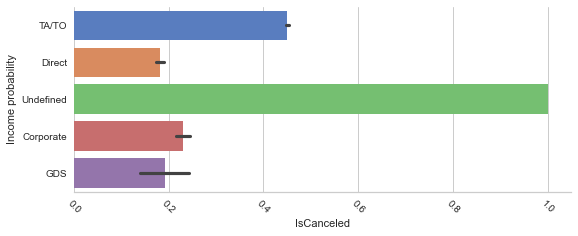

In [24]:
weight_of_variable(data,"DistributionChannel",target)

### ReservedRoomType

,Total count,Cancelled count,Weight
A,62595,27248,0.435306
D,11768,4147,0.352396
F,1791,700,0.390843
E,1553,505,0.325177
B,1115,368,0.330045
G,484,119,0.245868
C,14,5,0.357143
P,10,10,1.000000


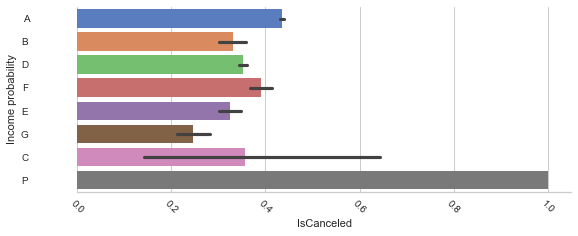

In [25]:
weight_of_variable(data,"ReservedRoomType",target)

In [41]:
weight_of_variable(data,"Country",target,plot = False, sortby="Weight")[:20]

,Total count,Cancelled count,Weight
BEN,3,3,1.000000
VGB,1,1,1.000000
KHM,2,2,1.000000
GLP,2,2,1.000000
GGY,2,2,1.000000
JEY,5,5,1.000000
MAC,15,15,1.000000
IMN,2,2,1.000000
MYT,2,2,1.000000
AND,2,2,1.000000


In [43]:
weight_of_variable(data,"Agent",target,plot = False, sortby="Weight")[:50]

,Total count,Cancelled count,Weight
78,29,29,1.000000
162,37,37,1.000000
235,29,29,1.000000
331,1,1,1.000000
287,8,8,1.000000
107,2,2,1.000000
276,8,8,1.000000
326,160,160,1.000000
47,26,26,1.000000
270,1,1,1.000000


In [44]:
weight_of_variable(data,"Company",target,plot = False, sortby="Weight")[:50]

,Total count,Cancelled count,Weight
316,2,2,1.000000
348,59,59,1.000000
122,18,18,1.000000
253,1,1,1.000000
202,38,38,1.000000
37,10,10,1.000000
279,8,8,1.000000
277,2,2,1.000000
43,18,18,1.000000
385,30,30,1.000000


## Check for multivariate corellation

locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000267DD4E7EB0>
Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x00000267DD4E7EB0> on colorbar
Setting pcolormesh


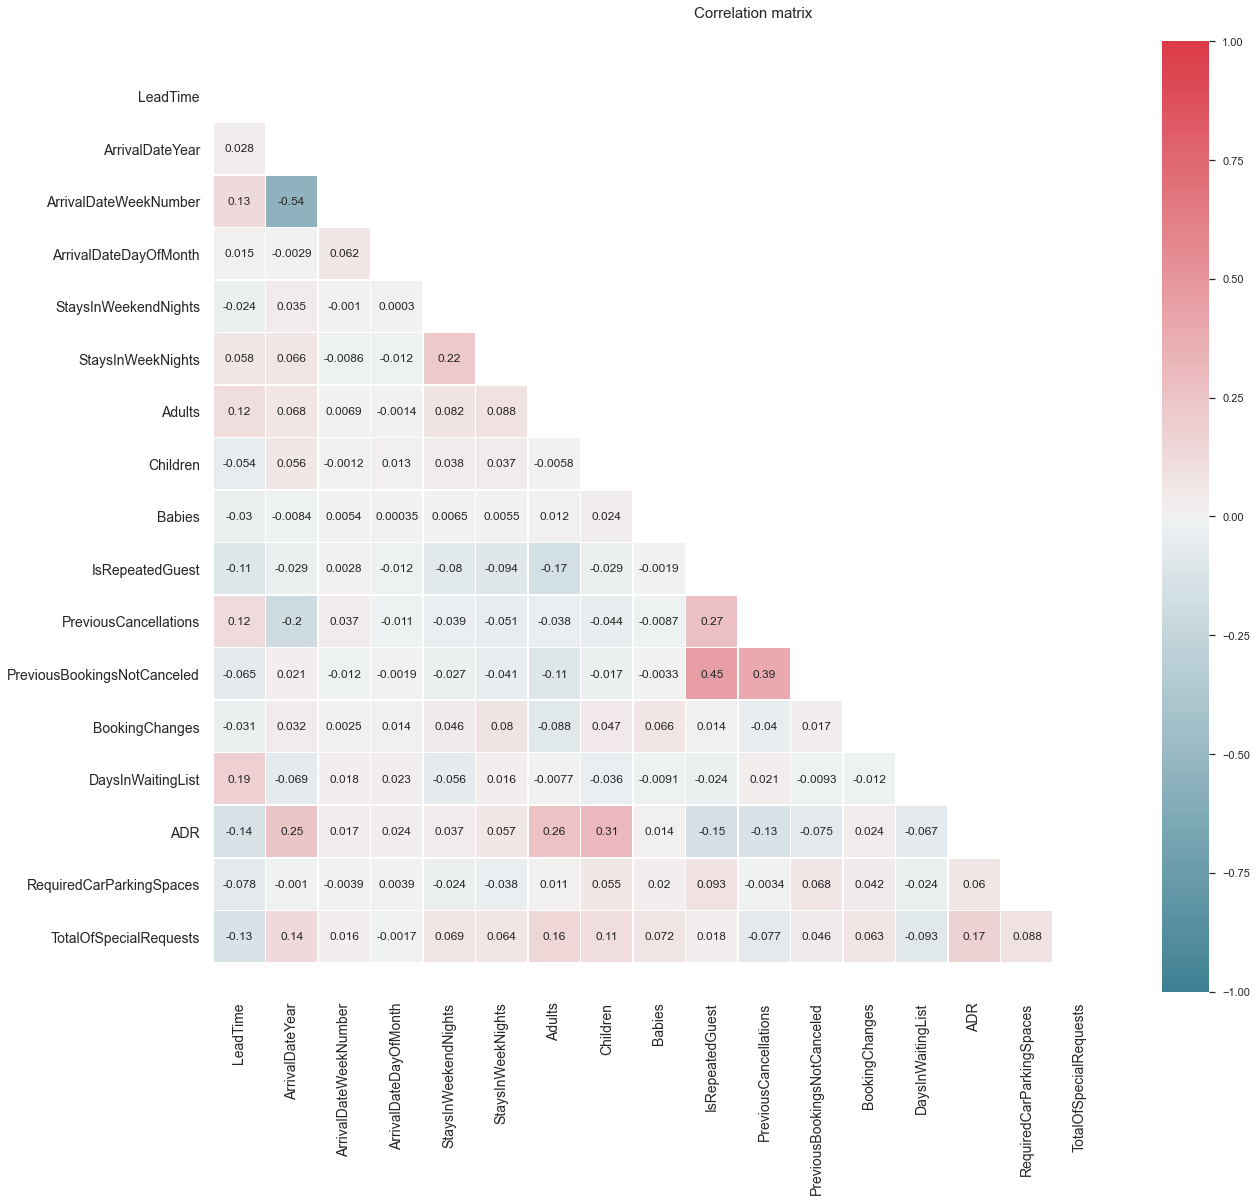

In [28]:
corrheatmap(data[numeric_feats], method = 'pearson')

# 3. Data preprocessing <a class="anchor" id="3"></a>

In [36]:
data.describe(exclude=[np.number])

,ArrivalDateMonth,Meal,Country,MarketSegment,DistributionChannel,ReservedRoomType,AssignedRoomType,DepositType,Agent,Company,CustomerType,ReservationStatus,ReservationStatusDate
count,79330,79330,79306,79330,79330,79330,79330,79330,79330,79330,79330,79330,79330
unique,12,4,166,8,5,8,9,3,224,208,4,3,864
top,August,BB,PRT,Online TA,TA/TO,A,A,No Deposit,9,NULL,Transient,Check-Out,2015-10-21
freq,8983,62305,30960,38748,68945,62595,57007,66442,31955,75641,59404,46228,1416


### Feature Engineering

We will create new feature called Average amount perpurchase of each customer by dividing the Monetary by the Frequency value

`Avr_purchase` = `Monetary` / `Freq`

### Data Transformation

### Outlier detection using DBSCAN

Performing DBSCAN in order to leave to the algorithm the automatic detection of the outliers

Since the number of outliers is not significant and we already treated them using the box-cox transfromation, we will not consider to drop them in this analysis

## 4. Predictive Modelling:

In [10]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('_________________________________________________________________________________________')
    print('                                       TRAIN                                          ')
    print('-----------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train,digits=4))
    print(confusion_matrix(y_train, pred_train))


    print('__________________________________________________________________________________________')
    print('                                      VALIDATION                                          ')
    print('------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val,digits=4))
    print(confusion_matrix(y_val, pred_val))
def enc_scl_pipe(X_train, y_train, X_test, enc_method, scaler = StandardScaler()): 
    X_train_encoded = X_train.copy()
    X_test_encoded= X_test.copy()
    # Set up feature to encode
    feature_to_encode = X_train.columns[X_train.dtypes == 'O'].tolist()
    
    if enc_method == 'label':
        for feat in feature_to_encode:
            # Initia the encoder model
            lbEncoder = LabelEncoder()
            # fit the train data
            lbEncoder.fit(X_train[feat])

            # transform training set
            X_train_encoded[feat] = lbEncoder.transform(X_train[feat])
            # transform test set
            X_test_encoded[feat] = lbEncoder.transform(X_test[feat])
            
    elif enc_method == 'glmm':
        # Initia the encoder model
        GLMMEncoder = ce.glmm.GLMMEncoder(verbose =0 ,binomial_target=False)
        # fit the train data
        GLMMEncoder.fit(X_train[feature_to_encode],y_train)
        # transform training set
        X_train_encoded[feature_to_encode] = GLMMEncoder.transform(X_train[feature_to_encode])
        # transform test set
        X_test_encoded[feature_to_encode] = GLMMEncoder.transform(X_test[feature_to_encode])
    else:
        raise 'No encoding method stated'
        
    # fit the scaler                    
    scaler.fit(X_train_encoded)
    # transform training set
    X_train_scaled = pd.DataFrame(scaler.transform(X_train_encoded), columns=X_train_encoded.columns, index=X_train_encoded.index)
    # transform test set
    X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded), columns=X_test_encoded.columns, index=X_test_encoded.index)
    
    return X_train_scaled, X_test_scaled, feature_to_encode

In [11]:
#From EDA, we have chosen features not to used:
train = data.drop(columns=['ReservationStatus','ReservationStatusDate','IsCanceled'])
target = data.loc[:,'IsCanceled']

In [12]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.3,  random_state=2)
X_train, X_test, _ =  enc_scl_pipe(X_train, y_train, X_test, enc_method='glmm', scaler=RobustScaler())

In [13]:
params = {'reg_alpha': 6.147694913504962,
 'reg_lambda': 0.002457826062076097,
 'colsample_bytree': 0.3,
 'subsample': 0.8,
 'learning_rate': 0.05,
 'max_depth': 5,
 'num_leaves': 30,
 'min_child_samples': 285,
 'random_state': 2,
 'verbose':-1,
 'n_estimators': 2000,
 'metric': 'rmse',
 'cat_smooth': 39}

In [14]:
notnulls_train = (np.sum(X_train.isna(),axis = 1) == 0)
notnulls_test = (np.sum(X_test.isna(),axis = 1) == 0)

In [15]:
X_train.loc[notnulls_train,:]

,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,Babies,...,AssignedRoomType,BookingChanges,DepositType,Agent,Company,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests
68173,-0.524823,1.0,-1.135306,-0.714286,0.533333,-0.5,-1.0,-2.0,0.0,0.0,...,-1.920756,0.0,0.000000,-2.156841,0.000000,0.0,0.000000,-2.136752,0.0,1.0
12192,-0.312057,0.0,0.708388,-0.190476,-0.933333,-0.5,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.693196,5.447141,0.000000,0.0,0.000000,0.854701,0.0,0.0
57794,-0.517730,0.0,0.208415,0.571429,0.266667,-0.5,-0.5,-1.0,0.0,0.0,...,0.000000,0.0,0.000000,-1.000000,-0.198773,0.0,0.000000,-0.106838,0.0,0.0
67742,-0.475177,1.0,-1.135306,-0.761905,0.133333,-0.5,-0.5,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,-0.042735,0.0,0.0
52811,-0.439716,0.0,-0.116334,0.095238,-0.400000,0.5,-0.5,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.833333,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44295,-0.439716,0.0,-0.718089,-0.857143,0.466667,-0.5,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,-0.149573,0.0,0.0
33867,1.354610,-1.0,-0.116334,0.047619,-0.466667,-0.5,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,3.374935,0.000000,0.0,0.036697,-0.811966,0.0,0.0
31019,0.482270,1.0,0.708388,-0.047619,0.800000,-0.5,-0.5,0.0,0.0,0.0,...,0.000000,0.0,0.693196,1.809503,0.000000,0.0,0.000000,0.534188,0.0,0.0
44566,-0.283688,0.0,-0.718089,-0.809524,0.800000,0.5,-1.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,-1.000000,0.000000,0.0,0.000000,-1.997863,0.0,1.0


In [16]:
scores = {}

model = LogisticRegression()
#First, measure the base-line model with full features
begin = time.perf_counter()

model.fit(X_train.loc[notnulls_train,:], y_train[notnulls_train])
# Run cross-validation on training set
train_score = accuracy_score(y_train[notnulls_train], model.predict(X_train.loc[notnulls_train,:]))
test_score = accuracy_score(y_test[notnulls_test], model.predict(X_test.loc[notnulls_test,:]))
# finish counting time
end = time.perf_counter()
# assign infomation
scores['Logistics Regression'] = [train_score, test_score ,round(end-begin,3)]

model = lgb.LGBMClassifier(boosting_type='gbdt',random_state = 2)
#First, measure the base-line model with full features
begin = time.perf_counter()
model.fit(X_train.loc[:,:], y_train[:])
# Run cross-validation on training set
train_score = accuracy_score(y_train, model.predict(X_train.loc[:,:]))
test_score = accuracy_score(y_test, model.predict(X_test.loc[:,:]))
# finish counting time
end = time.perf_counter()
# assign infomation
scores['LightGBM_baseline'] = [train_score, test_score ,round(end-begin,3)]

# Tunned models
model = lgb.LGBMClassifier(boosting_type='gbdt',**params)
#First, measure the base-line model with full features
begin = time.perf_counter()
model.fit(X_train.loc[:,:], y_train[:])
# Run cross-validation on training set
train_score = accuracy_score(y_train, model.predict(X_train.loc[:,:]))
test_score = accuracy_score(y_test, model.predict(X_test.loc[:,:]))
# finish counting time
end = time.perf_counter()
# assign infomation
scores['LightGBM_tuned'] = [train_score, test_score ,round(end-begin,3)]

final_score = pd.DataFrame.from_dict(scores, orient='index',columns=['Train','Test','Training time'])

In [17]:
final_score

,Train,Test,Training time
Logistics Regression,0.809502,0.806706,0.452
LightGBM_baseline,0.879545,0.870625,0.488
LightGBM_tuned,0.889935,0.874869,6.361


In [29]:
final_score

,Train,Test,Training time
Logistics Regression,0.812689,0.808429,0.228
LightGBM_baseline,0.880355,0.870751,0.458
LightGBM_tuned,0.890259,0.874449,5.605


In [84]:
metrics(y_train, model.predict(X_train.loc[:,:]), y_test, model.predict(X_test.loc[:,:]))

_________________________________________________________________________________________
                                       TRAIN                                          
-----------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8908    0.9252    0.9077     32371
           1     0.8895    0.8414    0.8648     23160

    accuracy                         0.8903     55531
   macro avg     0.8901    0.8833    0.8862     55531
weighted avg     0.8902    0.8903    0.8898     55531

[[29950  2421]
 [ 3673 19487]]
__________________________________________________________________________________________
                                      VALIDATION                                          
------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0     0.8760    0.9138    0.8945    

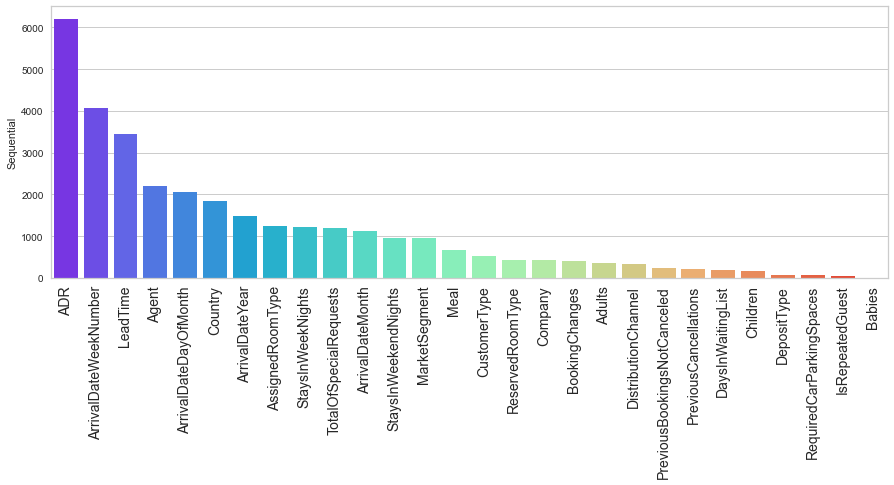

In [31]:
feats_imp = pd.Series(data = model.feature_importances_,index = X_train.columns)
feats_imp.sort_values(ascending=False,inplace=True)

fig,ax = plt.subplots(figsize=(15, 5), sharex=True)
# Generate some sequential data
sns.barplot(y=feats_imp.values, x= feats_imp.index, palette="rainbow", ax=ax,)
ax.set_ylabel("Sequential")
plt.xticks(rotation=90, fontsize = 14)
plt.show()

To be more practical in the deployment of the model, we also build an API to test the model prediction on new customer to know which cluster they belong to

In [56]:
test_id = 22

out_path = os.path.join(PROJECT_ROOT, 'app','model')
# Saving best model
best_dt = clf
dump(best_dt, os.path.join(out_path, 'best_decision_tree{}.joblib'.format(test_id)))

['C:\\Users\\Admin\\Documents\\GitHub\\Business_Cases_Group\\Case 1\\api\\app\\model\\best_decision_tree22.joblib']

## 5. Evaluation

### Evaluate results
The proposed model (K-means clustering) has performed a good result in both clusters size and R2 score, which tell that the models is good in classify different customer segments. The defined clusters show distinctive values in most of the features.

For better understanding the clusters, a decision tree model is created to re-classify the dataset. The prediction result on testset (30% of the dataset) is 91% which is a very good result. 

Features importance are measured and the two features showing huge discriminative ability is `Dryed` and `Age`, follow by less significant features such as `Perdeal`, `LTV` and `Avr_purchase`.

### Review process
Major steps conducted in the project:
- Feature engineering: `Avr_purchase` = `Monetary` / `Freq`
- Data transformation: Box-cox transformation
- Data normalization: Standard scaler
- Clustering: K-means algorithm
- Classification/ Predictive model: Decision Tree Classifier

All the steps are conducted successfully and contribute to the final result

We will proceed to deploy the proposed model as it already satisfies the business goals and the data mining goals.

## 6. Deployment:
Deployment is a crucial part of every business project. A machine learning model will not be able to drive values if it is not effectively deployed in the real-world context.


### Plan deployment
The dataset collected by IT department is in a very good condition as no missing value and data error was found during the exploratory process. However, to ensure the quality of the predictive model in future use as well as scalability of the clustering model if there are more data fed in, any newly collected data should have the same quality as the current one.

To test the deployment, we also create an API to predict the belonging cluster of any new customer.

Current objective achieved:
- Cluster analysis: The first result of the project is a cluster analysis with insightful information about each customer segments to support on marketing activities. The clusters are well defined with detailed profiling carried out to understand the key features and characteristics that distinguish each cluster from the others
- Predictive model and testing environment: The second objective is to deliver a predictive model that able to classify the segment of any current customer or predict that of any future customer with high accuracy. To test the deployment, we also create an API to predict the belonging cluster of any new customer. The API is currently under testing platform but the aim of it is to carry out a practical approach for any business stakeholder to easily understand the result of the project.

[**Test on API**]
- "Wine Explorer": `653,55,20,78473,0,0,20,18,826,445,7,67,4,26,2,1,1,36,5,0,0,0,0,0,0,0,0,0`
- "Wine Expert": `666,18,12,27984,1,0,4,56,39,-7,88,4,29,14,32,21,48,60,8,0,0,0,0,0,0,0,0,0`
- "Red Lover": `1049,42,16,61748,1,1,2,46,37,-6,70,86,1,11,1,1,55,59,7,0,0,0,0,0,0,0,1,1`

### Plan monitoring and maintenance
Future steps to successfully deploy the model:
- Develop fully functioned application: the final solution that able to be scale up to all the organization. The application should be able to allow continuous data fed in, continuous training and evaluation. The application will accept new data for prediction and validated results of new data as additional training data.
- Periodical maintenance plan should be able to continuous evaluate key metrics of the cluster analysis objectives which is, for example, the successful of marketing plan suggested by the analysis or new customer achieved through the findings.


### Produce final report and presentation
Will be introduce at the project presentation
